### Метрики качества классификации.

Сегодня мы научимся использовать различные метрики для оценки качества моделей.

Для начала загрузим данные с предыдущей домашней задачи с небольшим `сюрпризом`.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
!pip show pandas

Name: pandas
Version: 1.4.2
Summary: Powerful data structures for data analysis, time series, and statistics
Home-page: https://pandas.pydata.org
Author: The Pandas Development Team
Author-email: pandas-dev@python.org
License: BSD-3-Clause
Location: /opt/conda/lib/python3.8/site-packages
Requires: numpy, python-dateutil, pytz
Required-by: catboost, category-encoders, seaborn, statsmodels


In [3]:
!ls

HW11.ipynb  lost+found	processed_train.csv


In [4]:
data = pd.read_csv("processed_train.csv")

In [ ]:
data.head()

,EngineVersion,AppVersion,AvSigVersion,RtpStateBitfield,IsSxsPassiveMode,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,...,Platform_windows8,Processor_x64,Processor_x86,Census_DeviceFamily_Windows.Server,Census_OSArchitecture_arm64,Census_OSArchitecture_x86,Census_GenuineStateName_IS_GENUINE,Census_GenuineStateName_OFFLINE,Census_GenuineStateName_UNKNOWN,HasDetections
0,0.552153,0.530941,0.587952,7.0,0,53447.0,1.0,1.0,1,29,...,0,1,0,0,0,0,1,0,0,0
1,0.448751,0.528931,0.484434,7.0,0,53447.0,1.0,1.0,1,93,...,0,1,0,0,0,0,0,1,0,0
2,0.552153,0.530941,0.557522,7.0,0,53447.0,1.0,1.0,1,86,...,0,1,0,0,0,0,1,0,0,0
3,0.552153,0.530941,0.482759,7.0,0,53447.0,1.0,1.0,1,97,...,0,1,0,0,0,0,1,0,0,0
4,0.493175,0.530941,0.505721,7.0,0,53447.0,1.0,1.0,1,164,...,0,1,0,0,0,0,1,0,0,0


Один из гномов очень завидовал своим братьям, переплюнувшим его по `accuracy` в бонусном задании предыдущей домашней работы. Поэтому совершил следующее злодеяние: выкинул кучу объектов таким образом, чтобы баланс классов нарушился!

`Может, accuracy у них станет еще больше, зато преподаватель их отругает, ведь использовать accuracy при дисбалансе не очень-то хорошо!` - подумал гном

Замерьте количество объектов в порченном датафрейме.
В какой пропорции соотносятся классы теперь?

In [ ]:
### Your code is here
relate = data.HasDetections.value_counts().loc[1] / data.HasDetections.value_counts().loc[0]
print(round(relate, 2))



0.2


In [ ]:
data.HasDetections.value_counts()

,count
HasDetections,
0,99940
1,20012


In [ ]:
data_copy = data.copy(deep=True)

Произведем процедуру отложенной выборки:

In [5]:
y = data['HasDetections']
X = data.drop('HasDetections', axis=1)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test  = train_test_split(X, y,
                                                     test_size=0.25,
                                                     shuffle=True,
                                                     random_state=1)

Обучите логистическую регрессию с параметром `l2` регуляризации `C = 0.01` на порченном датасете.
Замерьте долю верно классифицированных объектов на трейне и на тесте. Можете использовать абсолютно любые конструкции, главное не забыть пронормировать данные с помощью `StandardScaler`

In [6]:
### Your code is here
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

scaler = StandardScaler()
X_train_t = scaler.fit_transform(X_train)
X_test_t = scaler.transform(X_test)

model = LogisticRegression(C=0.01)
model.fit(X_train_t, y_train)

y_predict_train = model.predict(X_train_t)
y_predict_test = model.predict(X_test_t)

acc_train = accuracy_score(y_predict_train, y_train)
acc_test = accuracy_score(y_predict_test, y_test)

print('Accuracy train score: ', round(acc_train,3))
print('Accuracy test score: ', round(acc_test,3))




Accuracy train score:  0.841
Accuracy test score:  0.842


Кажется, что, по сравнению с результатами в предыдущей домашней работе, мы построили куда более сильную модель. Но мы сильно заблуждаемся, если в это верим!

**Задание 2.**
Для бинарной классификации можно построить так называемую **confision matrix** (матрица ошибок), которая подсчитывает количество правильных и неправильных предсказаний и разделяет их по двум классам:

|          | a(x) = -1  | a(x) = +1  |
|----------|------------|------------|
|  y = -1  |     TN     |     FP     |
|  y = +1  |     FN     |     TP     |

* Positive/Negative отражает то, к какому классу определила объект наша модель $a(x)$, в нашем случае нулевой класс соответствует Negative (нет вируса), а единичный класс - Positive (есть вирус).

* True/False просто показывает совпало ли предсказание модели с реальным классом объекта, поэтому на главной диагонали стоят True, а на побочной False.

**2.1)** Постройте вручную матрицу ошибок на тестовой выборке, используя реальные и предсказанные вашей моделью метки классов. Потом сравните результат с методом `confusion_matrix` в `sklearn`.

In [7]:
### Your code is here
test_data = X_test
test_data['predict'] = y_predict_test
test_data['result'] = y_test


In [8]:
prediction = test_data[['predict', 'result']]

In [9]:
true_negative = prediction[(prediction.predict == 0) & (prediction.result == 0)].shape[0]
true_positive = prediction[(prediction.predict == 1) & (prediction.result == 1)].shape[0]
false_negative = prediction[(prediction.predict == 0) & (prediction.result == 1)].shape[0]
false_positive = prediction[(prediction.predict == 1) & (prediction.result == 0)].shape[0]

In [10]:
from sklearn.metrics import confusion_matrix

### Your code is here

print(true_negative, true_positive, false_negative, false_positive)

tn, fp, fn, tp = confusion_matrix(y_test, y_predict_test).ravel()

print(f'True Negative errors: {tn} vs {true_negative}')
print(f'False Positive errors: {fp} vs {false_positive}')
print(f'False Negative errors: {fn} vs {false_negative}')
print(f'True Positive errors: {tp} vs {true_positive}')





24726 527 4442 293
True Negative errors: 24726 vs 24726
False Positive errors: 293 vs 293
False Negative errors: 4442 vs 4442
True Positive errors: 527 vs 527


**2.2)** Посчитайте стандартную метрику Accuracy на тестовой выборке c помощью матрицы ошибок. Напомним, что это просто доля верно предсказанных меток:
$
ACC = \dfrac{TP + TN}{TP + TN + FP + FN}
$.

(Не стоит переводить accuracy как точность, так как под точностью иногда еще понимают precision, который является совсем другим показателем! Лучше всегда использовать английские версии метрик, чтобы не возникало недопониманий. )

In [11]:
### Your code is here
correct_predictions = prediction[prediction.predict + prediction.result != 1].shape[0]
print(correct_predictions / prediction.shape[0])






0.8421035080698946


Мы ожидаем, что полученная accuracy совпадет с той, что была подсчитана во время использования функции `cross_validate`

Мы знаем, что accuracy не является хорошим показателем качества модели при несбалансированных классах.

Допустим у нас 1000 объектов, где 990 имеют метку класса 0, а остальные 10 имеют метку 1. В нашем случае, класс 0 соответствует компьютерам, на которых нет вируса, а класс 1 - на которых есть. Тогда accuracy у константной модели, которая всегда предсказывает нулевой класс будет $0.99$, хотя задача как раз состоит в том, чтобы детектировать эти самые 10 объектов, которые соответствуют зараженным компьютерам.

При несбалансированных выборках с помощью матрицы ошибок можно посчитать следующие метрики:

* **Precision** показывает "точность" попадания нашего классификатора в положительный класс, то есть долю правильно предсказанных положительных объектов среди всех **предсказанных** положительных объектов.

* **Recall** показывает "полноту" предсказаний нашего классификатора, то есть долю правильно предсказанных положительных объектов среди всех **реальных** положительных объектов.

**2.3)** Посчитайте Precision и Recall с помощью матрицы ошибок. Потом сравните с реализацией в sklearn. Напомним формулы из лекции:

$$
Precision = \dfrac{TP}{TP + FP}, \quad Recall = \dfrac{TP}{TP + FN}
$$

In [12]:
from sklearn.metrics import recall_score, precision_score

### Your code is here

precision_ = true_positive / (true_positive + false_positive)
recall_ = true_positive / (false_negative + true_positive)


print('Hand made: ', precision_, recall_)
print('Library: ', precision_score(y_test, y_predict_test), recall_score(y_test, y_predict_test))




Hand made:  0.6426829268292683 0.10605755685248541
Library:  0.6426829268292683 0.10605755685248541


Теперь картина кажется не такой уж лучезарной!

Вспомним,

Метод `.predict` на самом деле берёт предсказанные вероятности для каждого класса и каждому объекту присваивает тот класс, у которого больше вероятность.

Так как мы сейчас занимаемся бинарной классификацией, то большая вероятность определяется просто сравнением с порогом 0.5.

**2.4)** Воспользуйтесь методом `.predict_proba` и с помощью сравнения с порогом 0.5 постройте вектор предсказаний. Проверьте результат на ранее предсказанных метках, вектора должны совпадать.

In [13]:
### Your code is here
prediction['predict_proba'] = model.predict_proba(X_test_t)[:, :1]

/tmp/ipykernel_99/2929337486.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['predict_proba'] = model.predict_proba(X_test_t)[:, :1]


In [14]:
prediction[prediction.predict_proba > 0.5].shape

(29168, 3)

In [ ]:
prediction[prediction.predict_proba <= 0.5].shape

(819, 3)

In [15]:
prediction.predict.value_counts()

0    29168
1      820
Name: predict, dtype: int64

**Задание 3.**
Решим бизнес задачу. \
**3.1)** Допустим, заказчик требует, чтобы наш классификатор в 60% случаев правильно предсказывал наличие вируса на компьютере, чтобы не беспокоить клиентов из-за ложноположительных результатов. \
Как решить эту задачу? =>
Надо подобрать порог, который максимизирует `recall` при условии, что `precision > 0.6`.

$$
(recall | precision > 0.6) \to \max_{thres}
$$

In [16]:
from sklearn.metrics import precision_recall_curve

### Строим всевозможные комбинации precision, recall, threshold

precision, recall, thres = precision_recall_curve(prediction.result, model.predict_proba(X_test_t)[:, 1])

### Находим такую тройку, при которой recall максимален, а precision > 0.6

ind = np.where(recall == recall[precision > 0.6].max())

print(f"Precison:\t {precision[ind][-1]}")
print(f"Recall: \t {recall[ind][-1]}")
print(f"Threshold:\t {thres[ind][-1]}")

Precison:	 0.6003717472118959
Recall: 	 0.1300060374320789
Threshold:	 0.4576697044816946


Теперь чтобы соответствовать установленным условиям, мы будем замерять вероятности для объектов и сравнивать и с найденным `Threshold`, который решает нашу задачу

**3.2)** Аналогично решите задачу, где заказчик требует, чтобы наш классификатор находил хотя бы 20% компьютеров с вирусом, среди всех действительно зараженных компьютеров.
$$
(precision | recall > 0.2) \to \max_{thres}
$$

In [17]:
from sklearn.metrics import precision_recall_curve

### Строим всевозможные комбинации precision, recall, threshold

precision, recall, thres = precision_recall_curve(prediction.result, model.predict_proba(X_test_t)[:, 1])

### Находим такую тройку, при которой precision максимален, а recall > 0.2

ind = np.where(precision == precision[recall > 0.2].max())

print(f"Precison:\t {precision[ind][-1]}")
print(f"Recall: \t {recall[ind][-1]}")
print(f"Threshold:\t {thres[ind][-1]}")

Precison:	 0.4923229321446261
Recall: 	 0.2000402495471926
Threshold:	 0.33074936212548517


**Задание 4.** На самом деле, можно объединить предыдущие две задачи и максимизировать взвешенную метрику, которая учитывает и Precision, и Recall. \
Посчитайте три такие метрики: среднее арифметическое, среднее геометрическое и минимум.
1) Найдите порог, который их максимизирует.
2) Выведите precision и recall, соответствующие этому порогу.
3) Нарисуйте линии уровня для каждой из этих метрик, используя функцию `level_lines`.
4) Изобразите точку $(recall, precision)$ соответствующую этому порогу на графике линий уровня.

$$
Arithm_{avg} = \dfrac{P + R}{2}, \quad Geom_{avg} = \sqrt{P \cdot R}, \quad Min = \min(P, R)
$$


In [18]:
def level_lines(func, name):
    x = np.linspace(0, 1.1, 100)
    y = np.linspace(0, 1.1, 100)

    X, Y = np.meshgrid(x, y)
    Z = func(X, Y)

    plt.figure(figsize=(5, 5))
    plt.title(name)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.contour(X, Y, Z, 15, cmap='plasma');

Precision:	 0.16995681677976557
Recall: 	 0.9979875226403703
Threshold:	 0.02198734808659953
 0.022,  0.170,  0.998


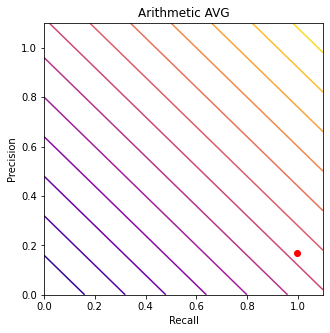

In [19]:
### Покажем на примере среднего арифметического, что должно у вас получиться

metric_func = lambda x, y: (x + y)/2

arithm_idx = (metric_func(precision, recall)).argmax()

print(f"Precision:\t {precision[arithm_idx]}")
print(f"Recall: \t {recall[arithm_idx]}")
print(f"Threshold:\t {thres[arithm_idx]}")

print(f"{thres[arithm_idx]: .3f}, {precision[arithm_idx]: .3f}, {recall[arithm_idx]: .3f}")

level_lines(metric_func, "Arithmetic AVG")
plt.plot(recall[arithm_idx], precision[arithm_idx], 'ro');

Precision:	  0.223
Recall: 	  0.812
Threshold:	  0.125
 0.125,  0.223,  0.812


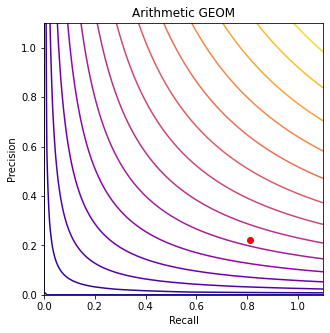

In [20]:
### Повторите для среднего геометрического
### Your code is here

metric_func = lambda x, y: np.sqrt(x * y)

arithm_idx = (metric_func(precision, recall)).argmax()

print(f"Precision:\t {precision[arithm_idx]: .3f}")
print(f"Recall: \t {recall[arithm_idx]: .3f}")
print(f"Threshold:\t {thres[arithm_idx]: .3f}")

print(f"{thres[arithm_idx]: .3f},{precision[arithm_idx]: .3f},{recall[arithm_idx]: .3f}")

level_lines(metric_func, "Arithmetic GEOM")
plt.plot(recall[arithm_idx], precision[arithm_idx], 'ro');

Precision:	  0.359
Recall: 	  0.359
Threshold:	  0.237


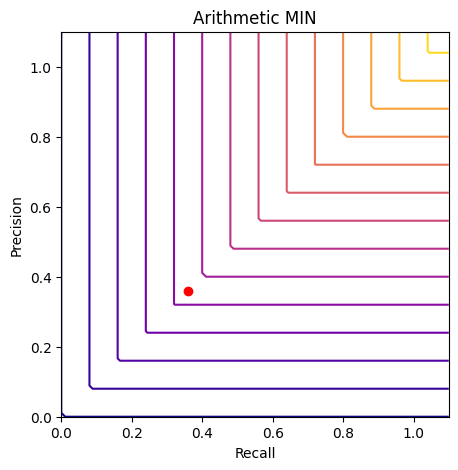

In [ ]:
### Повторите для минимума
### Your code is here

metric_func = lambda x, y: np.minimum(x, y)

arithm_idx = (metric_func(precision, recall)).argmax()

print(f"Precision:\t {precision[arithm_idx]: .3f}")
print(f"Recall: \t {recall[arithm_idx]: .3f}")
print(f"Threshold:\t {thres[arithm_idx]: .3f}")

level_lines(metric_func, "Arithmetic MIN")
plt.plot(recall[arithm_idx], precision[arithm_idx], 'ro');

**Задание 5.** Одним из самых распространенных показателей качества является **F-мера**, которая обобщает все вышерассмотренные метрики. Более того, в ней можно регулировать параметр $\beta^2$, который отвечает за предпочтение между precision и recall.
$$
F = \dfrac{(1 + \beta^2) P \cdot R}{\beta^2 P + R}
$$
* При $\beta^2 = 1$ и precision, и recall нам важны в равной степени.
* При $\beta^2 > 1$ предпочтение отдается recall. Похоже на решение задачи, где мы фиксируем приемлемое для нас значение precision и максимизируем recall.
* При $0 < \beta^2 < 1$ предпочтение отдается precision. Похоже на решение задачи, где мы фиксируем приемлемое для нас значение recall и максимизируем precision.

Найдите порог, который максимизирует:
1) F-меру с $\beta^2 = 1$,
2) F-меру с $\beta^2 = 0.05$,
3) F-меру с $\beta^2 = 4$.\
Для всех трех случаев выведите precision, recall, threshold и F-меру.
Нарисуйте линии уровня и точку, которая максимизирует F-меру по аналогии с предыдущим пунктом.

Precision:	 0.2849339014530755
Recall: 	 0.5248540953914268
Threshold:	 0.19234955640590176
 0.192, 0.285, 0.525, 0.369


/tmp/ipykernel_99/2906909250.py:6: RuntimeWarning: invalid value encountered in true_divide
  metric_func = lambda x, y: ((1 + 1) * x * y )/ (1 * x + y)


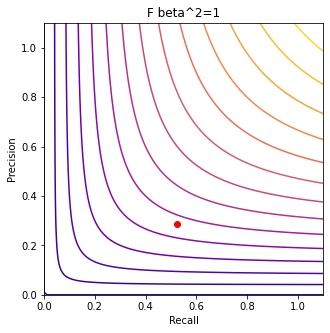

In [21]:
### Повторите для F-меры при \beta^2=1
### Выведите ее вместе с precision/recall/threshold
### Your code is here


metric_func = lambda x, y: ((1 + 1) * x * y )/ (1 * x + y)
f_metic = metric_func(precision, recall)
arithm_idx = (f_metic).argmax()

print(f"Precision:\t {precision[arithm_idx]}")
print(f"Recall: \t {recall[arithm_idx]}")
print(f"Threshold:\t {thres[arithm_idx]}")

print(f"{thres[arithm_idx]: .3f},{precision[arithm_idx]: .3f},{recall[arithm_idx]: .3f},{f_metic[arithm_idx]: .3f}")

level_lines(metric_func, "F beta^2=1")
plt.plot(recall[arithm_idx], precision[arithm_idx], 'ro');






Precision:	 0.642603550295858
Recall: 	 0.10927752062789294
Threshold:	 0.4973057964079164


<ipython-input-45-88ae60b0dd42>:7: RuntimeWarning: invalid value encountered in divide
  metric_func = lambda x, y: ((1 + 0.05) * x * y )/ (0.05 * x + y)


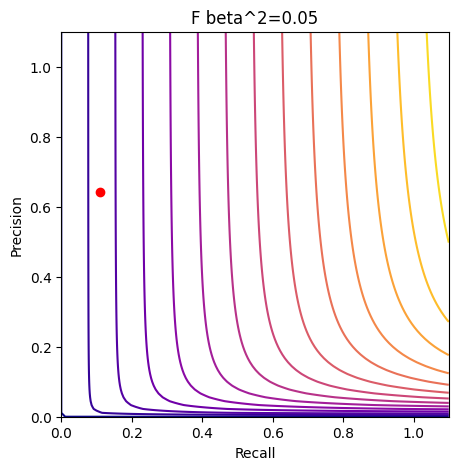

In [ ]:
### Повторите для F-меры при \beta^2=0.05
### Выведите ее вместе с precision/recall/threshold
### Your code is here



metric_func = lambda x, y: ((1 + 0.05) * x * y )/ (0.05 * x + y)

arithm_idx = (metric_func(precision, recall)).argmax()

print(f"Precision:\t {precision[arithm_idx]}")
print(f"Recall: \t {recall[arithm_idx]}")
print(f"Threshold:\t {thres[arithm_idx]}")

level_lines(metric_func, "F beta^2=0.05")
plt.plot(recall[arithm_idx], precision[arithm_idx], 'ro');







Precision:	 0.21052631578947367
Recall: 	 0.8597303280338097
Threshold:	 0.10928731456880099


<ipython-input-46-fdd87883f523>:7: RuntimeWarning: invalid value encountered in divide
  metric_func = lambda x, y: ((1 + 4) * x * y )/ (4 * x + y)


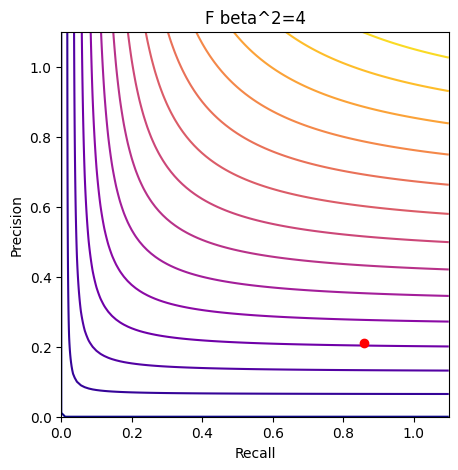

In [ ]:
### Повторите для F-меры при \beta^2=4
### Выведите ее вместе с precision/recall/threshold
### Your code is here



metric_func = lambda x, y: ((1 + 4) * x * y )/ (4 * x + y)

arithm_idx = (metric_func(precision, recall)).argmax()

print(f"Precision:\t {precision[arithm_idx]}")
print(f"Recall: \t {recall[arithm_idx]}")
print(f"Threshold:\t {thres[arithm_idx]}")

level_lines(metric_func, "F beta^2=4")
plt.plot(recall[arithm_idx], precision[arithm_idx], 'ro');





